In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from keras.optimizers import SGD
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping
from keras.regularizers import l1,l2
import math
from sklearn.metrics import mean_absolute_error,mean_squared_error
import keras
import random
from numba import cuda

random.seed(34)

%matplotlib inline


sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14,14
RANDOM_SEED = 42


Using TensorFlow backend.


In [2]:
from keras import backend as k

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [3]:
def metrics(X_filled,X_original):
    
    rmse = math.sqrt(((X_filled - X_original) ** 2).mean())
    mae= mean_absolute_error(X_filled , X_original)
    
    return rmse,mae

In [4]:
#original : complete dataset             DATASET 1, use to score predictions
#df_miss  : missing values dataset       DAtASET 2, use for predictions

original=pd.read_csv("./data/pro_act_2_A_clean.csv")
df_miss=pd.read_csv("./data/pro_act2_A_p0.1.csv")
df_missing_mask = np.isnan(df_miss)

In [5]:
# find indices of nans
a=np.argwhere(np.isnan(df_miss.values))
b=[tuple(i)for i in a]

In [6]:
# get random indices to make new nans

pairs1=[]
for i in range(int(0.25*df_miss.shape[1]*df_miss.shape[0])):
    random_x = random.randrange(df_miss.shape[0]) 
    random_y = random.randrange(df_miss.shape[1]) 
    pairs1.append((random_x,random_y))

In [7]:
# exclude indices that are nan already and duplicates
# final indices to make nans

res1 = list(set(pairs1)-set(b))


In [8]:
print(len(b))
print(len(pairs1))
print(len(res1))

50697
126743
100832


In [9]:
# get random indices to make new nans
random.seed(33)

pairs2=[]
for i in range(int(0.25*df_miss.shape[1]*df_miss.shape[0])):
    random_x = random.randrange(df_miss.shape[0]) 
    random_y = random.randrange(df_miss.shape[1]) 
    pairs2.append((random_x,random_y))
    
res2 = list(set(pairs2)-set(b))

print(len(b))
print(len(pairs2))
print(len(res2))

50697
126743
101061


In [10]:
# get random indices to make new nans
random.seed(345)

pairs3=[]
for i in range(int(0.25*df_miss.shape[1]*df_miss.shape[0])):
    random_x = random.randrange(df_miss.shape[0]) 
    random_y = random.randrange(df_miss.shape[1]) 
    pairs3.append((random_x,random_y))
    
res3 = list(set(pairs3)-set(b))

print(len(b))
print(len(pairs3))
print(len(res3))

50697
126743
100900


In [11]:
# get random indices to make new nans
random.seed(45747)

pairs4=[]
for i in range(int(0.25*df_miss.shape[1]*df_miss.shape[0])):
    random_x = random.randrange(df_miss.shape[0]) 
    random_y = random.randrange(df_miss.shape[1]) 
    pairs4.append((random_x,random_y))
    
res4 = list(set(pairs4)-set(b))

print(len(b))
print(len(pairs4))
print(len(res4))

50697
126743
100844


In [12]:
#df_ground  : new complete dataset filled with mean   DATASET 3, use to compute loss of DAE

df_ground=df_miss.fillna(df_miss.mean())

In [13]:
#df_train   : new missing values dataset              DATASET 4, use to feed and train DAE

df_train2=df_ground.copy()
for coo in pairs2:
    df_train2.iloc[coo[0],coo[1]]=np.nan
    
#df_train   : new missing values dataset              DATASET 4, use to feed and train DAE

df_train1=df_ground.copy()
for coo in pairs1:
    df_train1.iloc[coo[0],coo[1]]=np.nan
    
df_train=pd.concat([df_train1, df_train2],axis=0)

#df_train   : new missing values dataset              DATASET 4, use to feed and train DAE

df_train3=df_ground.copy()
for coo in pairs3:
    df_train3.iloc[coo[0],coo[1]]=np.nan
    
df_train=pd.concat([df_train, df_train3],axis=0)

#df_train   : new missing values dataset              DATASET 4, use to feed and train DAE

df_train4=df_ground.copy()
for coo in pairs4:
    df_train4.iloc[coo[0],coo[1]]=np.nan
    
df_train=pd.concat([df_train, df_train4],axis=0)

In [14]:

df_train.shape

(57940, 35)

In [15]:
miss=df_train
comp=pd.concat([df_ground,df_ground,df_ground,df_ground],axis=0)
missing_mask = np.isnan(miss)

In [16]:
miss.isnull().values.any()


True

In [17]:
#missa=miss.fillna(miss.mean())
#missa=miss.fillna(value=0)
missa=miss.fillna(value=-9)

In [18]:
out_train, out_test,in_train,in_test = train_test_split(comp,missa, test_size=0.3, random_state=1)


In [19]:
early=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='auto',restore_best_weights=True)

In [20]:
ad = keras.optimizers.Adam(lr=0.0005)


In [21]:
input = Input(shape=(35,))
encoded = Dense(25, activation='relu')(input)
encoded = Dense(15, activation='relu')(encoded)

encoded = Dense(11, activation='relu')(encoded)

decoded=  Dense(15, activation='relu')(encoded)

decoded=  Dense(25, activation='relu')(decoded)
decoded = Dense(35, activation='linear')(decoded)

autoencoder = Model(input, decoded)

autoencoder.compile(optimizer=ad, loss='mse')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                900       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_3 (Dense)              (None, 11)                176       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                180       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                400       
_________________________________________________________________
dense_6 (Dense)              (None, 35)                910       
Total para

In [22]:
history=autoencoder.fit(in_train, out_train,
                epochs=5000,
                batch_size=32,
                shuffle=True,
                validation_data=(in_test, out_test),
                       callbacks=[early])

Train on 40558 samples, validate on 17382 samples
Epoch 1/5000
40558/40558 [==============================] - 7s 163us/step - loss: 81780.6454 - val_loss: 8198.8437
Epoch 2/5000
40558/40558 [==============================] - 5s 127us/step - loss: 7521.1792 - val_loss: 7153.5329
Epoch 3/5000
40558/40558 [==============================] - 5s 128us/step - loss: 6396.7579 - val_loss: 5524.8265
Epoch 4/5000
40558/40558 [==============================] - 5s 131us/step - loss: 5073.4704 - val_loss: 4782.5125
Epoch 5/5000
40558/40558 [==============================] - 5s 130us/step - loss: 4061.1858 - val_loss: 3374.5066
Epoch 6/5000
40558/40558 [==============================] - 5s 130us/step - loss: 2782.3405 - val_loss: 2511.8095
Epoch 7/5000
40558/40558 [==============================] - 5s 130us/step - loss: 2324.5695 - val_loss: 2267.5758
Epoch 8/5000
40558/40558 [==============================] - 5s 131us/step - loss: 2161.2221 - val_loss: 2155.6718
Epoch 9/5000
40558/40558 [===========

Epoch 72/5000
40558/40558 [==============================] - 5s 134us/step - loss: 1314.0345 - val_loss: 1678.4553
Epoch 73/5000
40558/40558 [==============================] - 5s 128us/step - loss: 1309.8391 - val_loss: 1356.6201
Epoch 74/5000
40558/40558 [==============================] - 5s 128us/step - loss: 1301.7735 - val_loss: 1362.0770
Epoch 75/5000
40558/40558 [==============================] - 5s 130us/step - loss: 1301.4487 - val_loss: 1320.7871
Epoch 76/5000
40558/40558 [==============================] - 5s 131us/step - loss: 1301.6517 - val_loss: 1414.7293
Epoch 77/5000
40558/40558 [==============================] - 5s 128us/step - loss: 1302.1357 - val_loss: 1319.1251
Epoch 78/5000
40558/40558 [==============================] - 5s 128us/step - loss: 1281.4287 - val_loss: 1407.7844
Epoch 79/5000
40558/40558 [==============================] - 5s 128us/step - loss: 1289.3726 - val_loss: 1339.6931
Epoch 80/5000
40558/40558 [==============================] - 5s 128us/step - los

Epoch 143/5000
40558/40558 [==============================] - 5s 125us/step - loss: 1167.5653 - val_loss: 1208.9266
Epoch 144/5000
40558/40558 [==============================] - 6s 136us/step - loss: 1160.6324 - val_loss: 1268.1138
Epoch 145/5000
40558/40558 [==============================] - 6s 140us/step - loss: 1165.4675 - val_loss: 1258.7817
Epoch 146/5000
40558/40558 [==============================] - 6s 141us/step - loss: 1161.4014 - val_loss: 1198.8421
Epoch 147/5000
40558/40558 [==============================] - 5s 135us/step - loss: 1172.2791 - val_loss: 1241.2813
Epoch 148/5000
40558/40558 [==============================] - 6s 136us/step - loss: 1162.6194 - val_loss: 1213.6344
Epoch 149/5000
40558/40558 [==============================] - 5s 131us/step - loss: 1169.0547 - val_loss: 1244.2007
Epoch 150/5000
40558/40558 [==============================] - 5s 133us/step - loss: 1165.2330 - val_loss: 1208.9119
Epoch 151/5000
40558/40558 [==============================] - 5s 131us/s

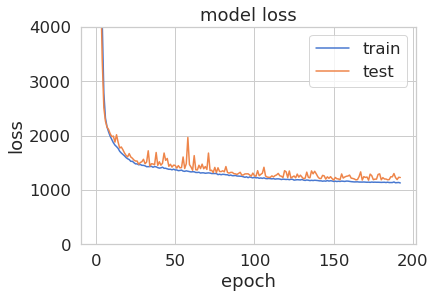

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim( 0,4000)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [24]:
#df_missa=df_miss.fillna(df_miss.mean())
#df_missa=df_miss.fillna(value=0)
df_missa=df_miss.fillna(value=-9)


In [25]:
ae=autoencoder.predict(df_missa)


In [26]:
df_miss[df_miss.isnull()] =ae


In [27]:
metrics(df_miss.values[df_missing_mask],original.values[df_missing_mask])

(63.85132663254028, 15.886098117043106)

In [28]:
cuda.select_device(0)
cuda.close()